
# MMF1921/MIE377 Style Backtesting Template

From the MIE377/MMF1921 Projects:

        The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

        This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

        # PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

This template for evaluating asset allocation algorithms is the exact same style as the one in MIE377.

Is it fast? No it is not.

Is it clear and relatively easy to follow? Yes it is.

There are a couple of moving parts:

* The database: see the Database folder for examples of where and how the data was processed. Download SQLLite viewer to explore the data and look at the queries in the notebooks to understand what data is in there
* The services: in the services folder there are some helpers to extract the data (data_retrieval.py), estimate means and covariances (estimators.py), and optimizers (optimization.py)
* Strategies are also defined in the services folder. The current convention is that a strategy takes in data (returns and factor returns) and outputs an allocation.
* Typically, the strategies will use some form of estimator and an optimizer come up with allocations.

If you do not want to deal with the database then use the MIE377_Project_Main template and copy cells 2.1 and 2.2 into the appropriate spot
and replace 

        x[:,t] = project_function(periodReturns, periodFactRet)

with

        x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

# 1. Read input files

In [1]:
import time
import math
from Database.services.database import Database
from sqlalchemy import inspect
from services.data_retreival import *
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.strategies import *
from services.optimization_layers import *
from services.optimization import *

Database.initialize("sqlite:///Database//financial_db.sqlite") #for courses replace this with a flat file
inspector = inspect(Database.engine)
print(inspector.get_table_names())

universe = 'ETF'
imputation_method = 'Multivariate'
#exponential params


adjClose = pd.read_csv("flat_files/MonthlyAssetPrices"+ universe + ".csv", index_col=0, header = 1).iloc[1:,:]

daily_adjClose =  pd.read_csv("flat_files/DailyAssetPrices"+universe + ".csv", index_col=0, header = 1).iloc[1:,:]

TechnicalAnalysis = pd.read_csv("flat_files/TechnicalAnalysis" + universe + ".csv", index_col=[0,1])

if universe ==  'SP':
    FinancialRatios = pd.read_csv("flat_files/" + imputation_method + "WRDS.csv", index_col=[0,1])
    TechnicalAnalysis.index.names = FinancialRatios.index.names
    ContextualInfo = TechnicalAnalysis.merge(FinancialRatios, how = 'inner', left_index=True, right_index=True)

else:
    TechnicalAnalysis.index.names = ['date', 'ticker']
    ContextualInfo = TechnicalAnalysis


['asset_id', 'currency_id', 'equities_series', 'equity_index_id', 'exchange_id', 'factor_id', 'factors', 'frequency_id', 'fundamentals', 'metric_id', 'source_id', 'ticker_id', 'ticker_index_membership', 'tiingo_tickers']


In [2]:
adjClose.index = pd.to_datetime(adjClose.index, format='%Y-%m-%d').tz_localize(None)
daily_adjClose.index = pd.to_datetime(daily_adjClose.index, format='%Y-%m-%d').tz_localize(None)
ContextualInfo.index = ContextualInfo.index.set_levels([pd.to_datetime(ContextualInfo.index.levels[0]).tz_localize(None), ContextualInfo.index.levels[1]])

In [3]:
print("The earliest possible start date")
max(daily_adjClose.index.unique()[0], ContextualInfo.index.get_level_values('date').unique()[0], adjClose.index.unique()[0])

The earliest possible start date


Timestamp('2006-01-31 00:00:00')

In [4]:
print("The latest possible start date")
min(daily_adjClose.index.unique()[-1], ContextualInfo.index.get_level_values('date').unique()[-1], adjClose.index.unique()[-1])

The latest possible start date


Timestamp('2023-04-21 00:00:00')

In [5]:
# start_date = pd.to_datetime('1996-11-30', format = '%Y-%m-%d')
#
# end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

start_date = pd.to_datetime('2006-05-31', format = '%Y-%m-%d')

end_date = pd.to_datetime('2022-12-31', format = '%Y-%m-%d')

factors = ('Mkt-RF', 'RF')

factorRet = get_monthly_factors(factors, start_date, end_date, Database)

factorRet = factorRet.droplevel(0, axis = 1)
factorRet.columns = [col.strip() for col in factorRet.columns]

In [6]:
adjClose = adjClose[start_date:end_date]
daily_adjClose = daily_adjClose[start_date:end_date]
idx = pd.IndexSlice
ContextualInfo = ContextualInfo.loc[idx[start_date:end_date, :], :]

In [7]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months) - but actually units of data
investPeriod = 6

# divide the factor returns by 100
factorRet = factorRet/100

#rf and factor returns
#drop the first observation to align the dataset with the returns data that will
#result
factorRet = factorRet.iloc[1:, :]

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

In [8]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [9]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values) # risk adjusted returns
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [10]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

### 2.1 Some Standard Allocation Strategies

In [11]:
class environment:
    """
    an object that keeps track of the variables in the backtester
    """
    def __init__(self):
        self.periodReturns = None
        self.periodFactRet = None
        self.period_daily_adjClose = None
        self.period_Context = None

class general_strategy:
    """
    a general strategy where the estimator and optimizer are specified, makes all the other strategies obsolete
    """

    def __init__(self, estimator, optimizer, NumObs=36, investor_preferences=None):

        self.NumObs = NumObs  # number of observations to use
        self.estimator = estimator  # estimator is a function
        self.optimizer = optimizer
        self.investor_preferences = investor_preferences #kappa, K, q, epsilon, C, turnover limit
        self.extract_estimation_info=None
        self.extract_optimization_info=None
        self.current_results = None
        self.current_estimates = None

    def execute_strategy(self, periodReturns, factorReturns, environment = None):
        """
        executes the portfolio allocation strategy based on the parameters in the __init__

        :param additional_optimization_info:
        :param additional_estimation_info:
        :param additional_info:
        :param factorReturns:
        :param periodReturns:
        :return:x
        """

        # Estimation Step
        if self.extract_estimation_info is not None:
            estimation_params= self.extract_estimation_info(self, environment)
        else:
            estimation_params = None

        T, n = periodReturns.shape
        # get the last T observations
        returns = periodReturns.iloc[(-1) * self.NumObs:, :]
        factRet = factorReturns.iloc[(-1) * self.NumObs:, :]

        if estimation_params is None:
            estimates = self.estimator(returns, factRet)
        else:
            estimates = self.estimator(**estimation_params)

        # Optimization Step
        self.current_estimates = estimates
        if self.extract_optimization_info is not None:
            optimization_params= self.extract_optimization_info(self, environment)
        else:
            optimization_params = None


        if optimization_params is None:
            x = self.optimizer(*estimates)
            results = {'x':x}
        else:
            results = self.optimizer(**optimization_params) #solution, optimality gap, time to solve
            if type(results) != dict:
                warnings.warn("Optimizer interaction with environment does not return a dict")
                results = {'x':results}

        self.current_results = results

        return results['x']

In [93]:
def MVO_v3(mu, Q, target_index):
    """
    #---------------------------------------------------------------------- Use this function to construct an example of a MVO portfolio.
    #
    # An example of an MVO implementation is given below. You can use this
    # version of MVO if you like, but feel free to modify this code as much
    # as you need to. You can also change the inputs and outputs to suit
    # your needs.

    # You may use quadprog, Gurobi, or any other optimizer you are familiar
    # with. Just be sure to include comments in your code.

    # *************** WRITE YOUR CODE HERE ***************
    #----------------------------------------------------------------------
    """

    # Find the total number of assets
    n = len(mu)

    # Set the target as the average expected return of all assets
    targetRet = mu[target_index]

    # Disallow short sales
    lb = np.zeros(n)

    # Add the expected return constraint
    A = -1 * mu.T
    b = -1 * targetRet

    # constrain weights to sum to 1
    Aeq = np.ones([1, n])
    beq = 1
    covariance_sqrt = np.real(sqrtm(Q))
    # Define and solve using CVXPY
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize((1 / 2) * cp.sum_squares(covariance_sqrt @ x)),
                      [A @ x <= b,
                       Aeq @ x == beq,
                       x >= lb])
    prob.solve(verbose=False, solver = 'ECOS')
    return {'x': x.value}


In [94]:
#Some strategies (uncomment this or the next cell to pick a strategy to test)
# Strategy = general_strategy(sample_estimator, MVO, NumObs=48)  #the general strategy object takes an estimator function and an optimizer function
#                                                                #the only constraint is that the estimators outputs are the optimizers inputs

#investor preferences (static throughout the backtest)
k = 6*20 #estimation
alpha= 1 - 0.985 #estimation
return_premium = 2.2 #optimization
cardinality_ratio = 0.3 #optimization
q = 1
C = 10**(-3)
epsilon = 10**(-3)
target_index = 'SPY'

investor_preferences = {'k':k, 'alpha':alpha, 'premium':return_premium,
                        'target_index':target_index}

Strategy = general_strategy(exponential_weighted_estimator, MVO_v3,
                            investor_preferences = investor_preferences)

def populate_exponential_weighted_estimator_from_environment(Strategy, environment):

    estimation_info = {}
    estimation_info['k'] = Strategy.investor_preferences['k']
    estimation_info['alpha'] =  Strategy.investor_preferences['alpha']
    estimation_info['daily_prices'] = environment.period_daily_adjClose
    return estimation_info

def populate_mvo(Strategy, environment):
    optimization_info = {}
    optimization_info['mu'] = Strategy.current_estimates[0] #mean
    optimization_info['Q'] = Strategy.current_estimates[1] #covariance
    return optimization_info

def populate_mvo_v2(Strategy, environment):
    optimization_info = {}
    optimization_info['mu'] = Strategy.current_estimates[0] #mean
    optimization_info['Q'] = Strategy.current_estimates[1] #covariance
    optimization_info['premium'] = Strategy.investor_preferences['premium']
    return optimization_info

def populate_mvo_v3(Strategy, environment):
    optimization_info = {}
    optimization_info['mu'] = Strategy.current_estimates[0] #mean
    optimization_info['Q'] = Strategy.current_estimates[1] #covariance
    target_index_str = Strategy.investor_preferences['target_index']
    optimization_info['target_index'] = environment.periodReturns.columns.get_loc(target_index_str)
    return optimization_info

Strategy.extract_estimation_info = populate_exponential_weighted_estimator_from_environment

Strategy.extract_optimization_info = populate_mvo_v3

env = environment()
# see strategy script for different options OLS_RP() #OLS_MVO() #HistoricalMeanVarianceOptimization()

In [96]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=1)

#End of the first investment period
#testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days = 1)
testEnd = testStart + pd.offsets.MonthBegin(investPeriod) - pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

In [97]:
print("Test Start", testStart)
print("Test End", testEnd)
print("Calibration End", calEnd)

Test Start 2007-06-30 00:00:00
Test End 2007-11-30 00:00:00
Calibration End 2007-06-29 00:00:00


In [98]:
# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

In [99]:
# Number of assets
n  = len(tickers)

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    #take the last available contextual observations
    period_daily_adjClose = daily_adjClose[daily_adjClose.index <= calEnd]
    period_Context_idx = ContextualInfo.index.get_level_values('date') <= calEnd
    period_Context = ContextualInfo.iloc[period_Context_idx].groupby('ticker').last()

    env.periodReturns = periodReturns
    env.periodFactRet = periodFactRet
    env.period_daily_adjClose = period_daily_adjClose
    env.period_Context = period_Context
    #there should be a feature vector for each asset
    assert len(period_Context) == n

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
    else:
        currentVal[t] = currentPrices @  NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    #----------------------------------------------------------------------
    # add in the estimation info

    x[:,t] = Strategy.execute_strategy(periodReturns, periodFactRet, environment=env) #equal_weight(periodReturns) #StrategyFunction(periodReturns, periodFactRet, x0[:,t]);

    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum(np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

C:\Users\david\anaconda3\envs\forms\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# 3. Results

In [100]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))

Elasped time is 33.743000984191895 seconds
Sharpe ratio:  0.14329193539490861
Avg. turnover:  1.4387127182281603


### Observations

        The end to end strategy has the following stats when we use 15 observations:
        Elasped time is 27.749337434768677 seconds
        Sharpe ratio:  0.36926056542515073
        Avg. turnover:  0.2846570354951544

        Standard MVO has the following stats when we use 15 observations::
        
        Elasped time is 1.1906468868255615 seconds
        Sharpe ratio:  0.35584233976844887
        Avg. turnover:  0.6967647038270909

        The end to end strategy has the following stats when we use 35 observations:
        
        Elasped time is 16.95100688934326 seconds
        Sharpe ratio:  0.33129478714103455
        Avg. turnover:  0.13229814142751284

        Standard MVO has the following stats when we use 35 observations:
        
        Elasped time is 1.2436742782592773 seconds
        Sharpe ratio:  0.2997765726515852
        Avg. turnover:  0.25328429647155937


<Figure size 640x480 with 0 Axes>

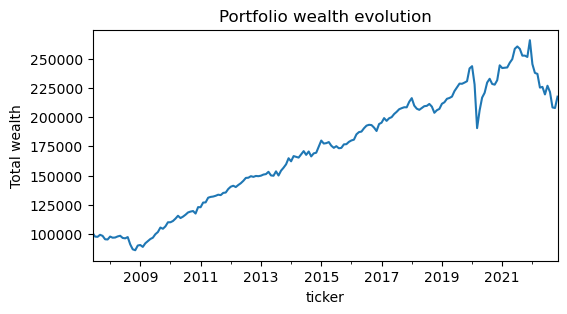

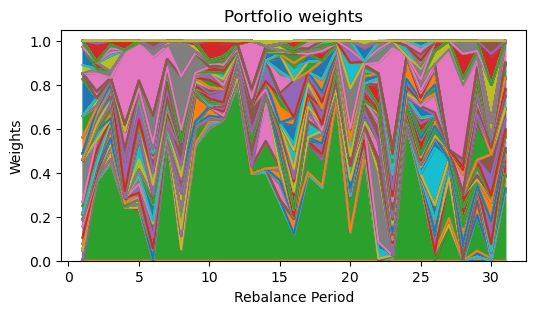

In [101]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
if n <= 20:
    legend_bool = True
else:
    legend_bool = False
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = legend_bool, stacked = True)
if legend_bool:
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

### 0.12% maximum absolute difference between the returns generated via Python and returns generated via MATLAB can be observed

### Terminal wealth between MATLAB and Python is within 0.1%

In [102]:
weights.iloc[:, 0].sort_values()

RQI    7.824923e-13
JOF    8.552589e-13
EZA    9.178923e-13
RFI    9.311040e-13
IYR    1.015149e-12
           ...     
PCF    7.364924e-02
USA    8.219899e-02
PIM    9.762207e-02
PPT    1.666855e-01
MHI    1.917508e-01
Name: 1, Length: 299, dtype: float64

In [103]:
(np.abs(daily_adjClose.diff().dropna()) <= 0.001).sum().sort_values()

IWM      9
IJH     10
MDY     10
VBK     11
SPY     12
      ... 
DHF    696
CIF    704
BHV    710
MIN    710
NOM    823
Length: 299, dtype: int64

In [104]:
# Calculate the portfolio Sharpe ratio
ticker_rets = adjClose.pct_change(1).iloc[1:,]
ticker_rets = ticker_rets.loc[portfRets.index]

tickerExRets = ticker_rets.subtract(riskFree[(riskFree.index >= ticker_rets.index[0])&(riskFree.index <= ticker_rets.index[-1])], axis = 0)

tickerSR = ((tickerExRets + 1).apply(gmean, axis=0) - 1)/tickerExRets.std()

In [105]:
(12**0.5)*tickerSR.sort_values(ascending=False)

VDC    0.704875
XLP    0.696787
XLV    0.686137
VHT    0.684758
IYH    0.680974
         ...   
EWP   -0.077192
EWO   -0.088028
EWI   -0.126377
OIH   -0.181022
CEE   -0.258633
Length: 299, dtype: float64

In [106]:
tickerSR['SPY']

0.13896710534105836